This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [1]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import theano.tensor as tt
import scipy
import scipy.stats as stats
import seaborn as sns

import rasterio as rio
from rasterio import mask
import geopandas as gpd
from shapely.geometry import shape
import xarray as xr
import rioxarray
import fiona

import optuna
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split

from utils import *
from params import *
tqdm.pandas()

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Pre-Processing

In [6]:
df, basin_idx, catchment_idx, coords = read_data(file_dir='../data/hierarchical_septics_v3.csv',
        cols=['ppt_2013', 'water_dist', 'hydraulic_c','median_hse', 'dem', 'flow'], is_balanced=True, is_multilevel=True)

balancing...
repairs: 7.6567198704603285%, non-repairs: 92.34328012953968%
processing soil hydraulic data...
acquiring housing information...
processing DEM and flow information...


# Multilevel Bayesian Model

- Group septic systems based on their sub-basin (~1560) and basin (~380) levels
- The effect of precipitation, distance to water bodies, soil characteristic, housing, topography to septic's status

## Empirical Distributions
Empirical analysis for 

1. distance to water bodies, precipitation: `01 hierarchical_bayesian_twovars`
2. soil hydraulic conductivity: `02 hierarchical_bayesian_threevars`
3. housing values: `03 hierarchical_bayesian_housing`

The new variable, flow accumulation or DEM ($f$):

$$
\begin{align}
    \textbf{Flow or DEM parameters}\\
    \beta_{f,k} \sim \Gamma_{f,k}(\alpha = \alpha_f, \beta=\beta_f)\\
    \alpha_f \sim HN_f(\sigma=1)\\
    \beta_f \sim HN_f(\sigma=5)\\
\end{align}
$$

The full hierarchical bayesian formula is as follows:
$$
\begin{align}
    Y_{k} \sim Bernoulli(\theta_{k})\\
    \theta_{k} = \sigma(\beta_{0,k} + \beta_{w,k}.waterdist + \beta_{p,k}.precip + \beta_{h_k}.hydraulics + \beta_{v,k}.housing + \beta_{f,k}.flow)\\
    \textbf{Intercept parameters}\\
    \beta_{0,k} \sim N_{0,k}(\mu=\mu_{0}, \sigma=\theta_{0})\\
    \mu_{0} \sim HN_0(\sigma=10), \quad \theta_{0} \sim HN_0(\sigma=10)\\
    \textbf{Water distance parameters}\\
    \beta_{w,k} \sim \Gamma_{w,k}(\alpha=\alpha_w, \beta=\beta_w)\\
    \alpha_w \sim HN_w(\sigma=1), \quad \beta_w \sim HN_w(\sigma=5)\\
    \textbf{Precipitation parameters}\\
    \beta_{p,k} \sim HN_{p,k}(\sigma=\sigma_p)\\
    \sigma_p \sim HN_p(\sigma=10)\\
    \textbf{Hydraulics parameters}\\
    \beta_{h,k} \sim U_{h,k}(lower=0,upper=\sigma_h)\\
    \sigma_h \sim HN_h(\sigma=10)\\
    \textbf{Housing parameters}\\
    \beta_{v,k} \sim HN_{v,k}(\sigma=\sigma_v)\\
    \sigma_v \sim HN_v(\sigma=10)\\
    \textbf{Flow/DEM parameters}\\
    \beta_{f,k} \sim \Gamma_{f,k}(\alpha=\alpha_f, \beta=\beta_f)\\
    \alpha_f \sim HN_f(\sigma=1), \quad \beta_f \sim HN_f(\sigma=5)\\
    \text{the subscript $w$, $p$, $h$, and $v$ denote distance to water bodies, precipitation, hydraulics respectively, and housing value at the $k$-th basin}\\
    \text{$\sigma$ (inverse logistic) function returns the binary value of 0 (repair) or 1 (new/addition)}
\end{align}
$$

In [21]:
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    catchment = pm.Data('catchment', catchment_idx, dims='septic')
    water_d = pm.Data('water_d', df.water_dist_norm.values, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2013_norm.values, dims='septic')

    # global model parameters
    wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.HalfNormal("ppt_mu", sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    mu_inter = pm.HalfNormal('mu_inter', sigma=10)
    sigma_inter = pm.HalfNormal('sigma_inter', sigma=10)
    
    # catchment parameters
    wtr_beta_c = pm.HalfNormal("wtr_beta_c", sigma=wtr_beta, dims='catchment')
    ppt_mu_c = pm.Normal("ppt_mu_c", mu=0, sigma=ppt_mu, dims='catchment')
    ppt_sig_c = pm.HalfNormal("ppt_sig_c", sigma=ppt_sig, dims='catchment')
    mu_inter_c = pm.HalfNormal('mu_inter_c', sigma=mu_inter, dims='catchment')
    sigma_inter_c = pm.HalfNormal('sigma_inter_c', sigma=sigma_inter, dims='catchment')

    # basin-specific model parameters
    wtr_dist = pm.Exponential("wtr_dist", lam=wtr_beta_c.mean(), dims="basin")
    ppt = pm.Normal("ppt", mu=ppt_mu_c.mean(), sigma=ppt_sig_c.mean(), dims="basin")
    c = pm.Normal('c', mu=mu_inter_c.mean(), sigma=sigma_inter_c.mean(), dims="basin")
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + wtr_dist[basin] * water_d 
                                    + ppt[basin] * ppt_d
                                   )

    # likelihood of observed data
    priors = pm.sample_prior_predictive(samples=500)
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=500, cores=4, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, ppt, wtr_dist, sigma_inter_c, mu_inter_c, ppt_sig_c, ppt_mu_c, wtr_beta_c, sigma_inter, mu_inter, ppt_sig, ppt_mu, wtr_beta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [23]:
# evaluate model (just dem)
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

accuracy is: 90.6832298136646%


In [84]:
# evaluate model (just flow)
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 90.1840490797546%


In [69]:
# evaluate model (both dem and flow)
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 90.49079754601227%


# Evaluation

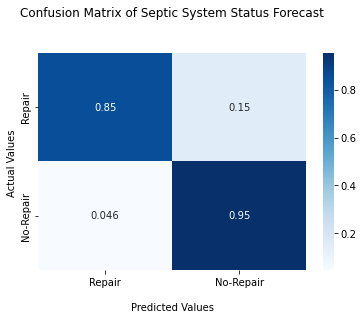

In [16]:
plot_confusion(y, y_pred)

array([[<AxesSubplot:title={'center':'wtr_dist\nWest Chickamauga Creek'}>,
        <AxesSubplot:title={'center':'ppt\nWest Chickamauga Creek'}>,
        <AxesSubplot:title={'center':'hydr\nWest Chickamauga Creek'}>],
       [<AxesSubplot:title={'center':'hse\nWest Chickamauga Creek'}>,
        <AxesSubplot:title={'center':'flow\nWest Chickamauga Creek'}>,
        <AxesSubplot:>]], dtype=object)

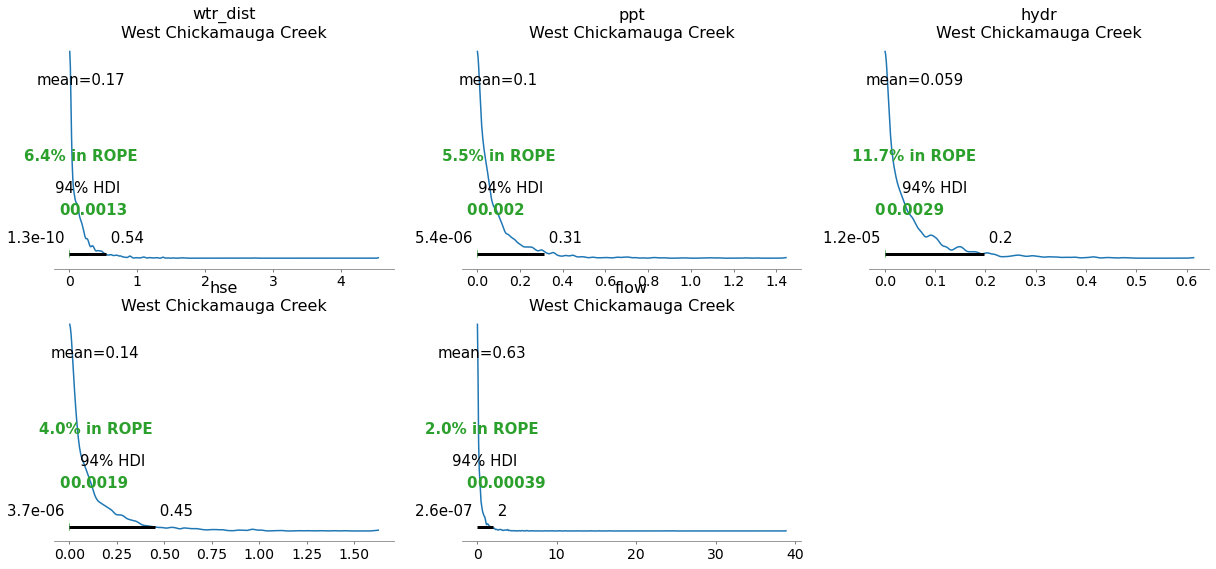

In [17]:
"""
posterior distribution with high density interval (HDI) and region of practical equivalence (ROPE)
analog of ROPE in frequentist statistics: null hypothesis (instead of point, in Bayesian we define a region)
region interval: [0, 0.01 * std] for normalized values according to Kruschke (2018)

"""
rope = {'wtr_dist': [{'rope': (0, df.water_dist_norm.values.std() * 0.01)}], 
        'ppt': [{'rope': (0, df.ppt_2013_norm.values.std() * 0.01)}],
        'hydr': [{'rope': (0, df.hydraulic_c_norm.values.std() * 0.01)}],
        'hse': [{'rope': (0, df.median_hse_norm.values.std() * 0.01)}],
        'flow': [{'rope': (0, df.flow_norm.values.std() * 0.01)}]
       }
az.plot_posterior(trace, coords=sample_coords, var_names=var_names, rope=rope)

# Archive

array([[<AxesSubplot:ylabel='ppt\nWest Chickamauga Creek'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='hydr\nWest Chickamauga Creek'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='hse\nWest Chickamauga Creek'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='wtr_dist\nWest Chickamauga Creek', ylabel='flow\nWest Chickamauga Creek'>,
        <AxesSubplot:xlabel='ppt\nWest Chickamauga Creek'>,
        <AxesSubplot:xlabel='hydr\nWest Chickamauga Creek'>,
        <AxesSubplot:xlabel='hse\nWest Chickamauga Creek'>]], dtype=object)

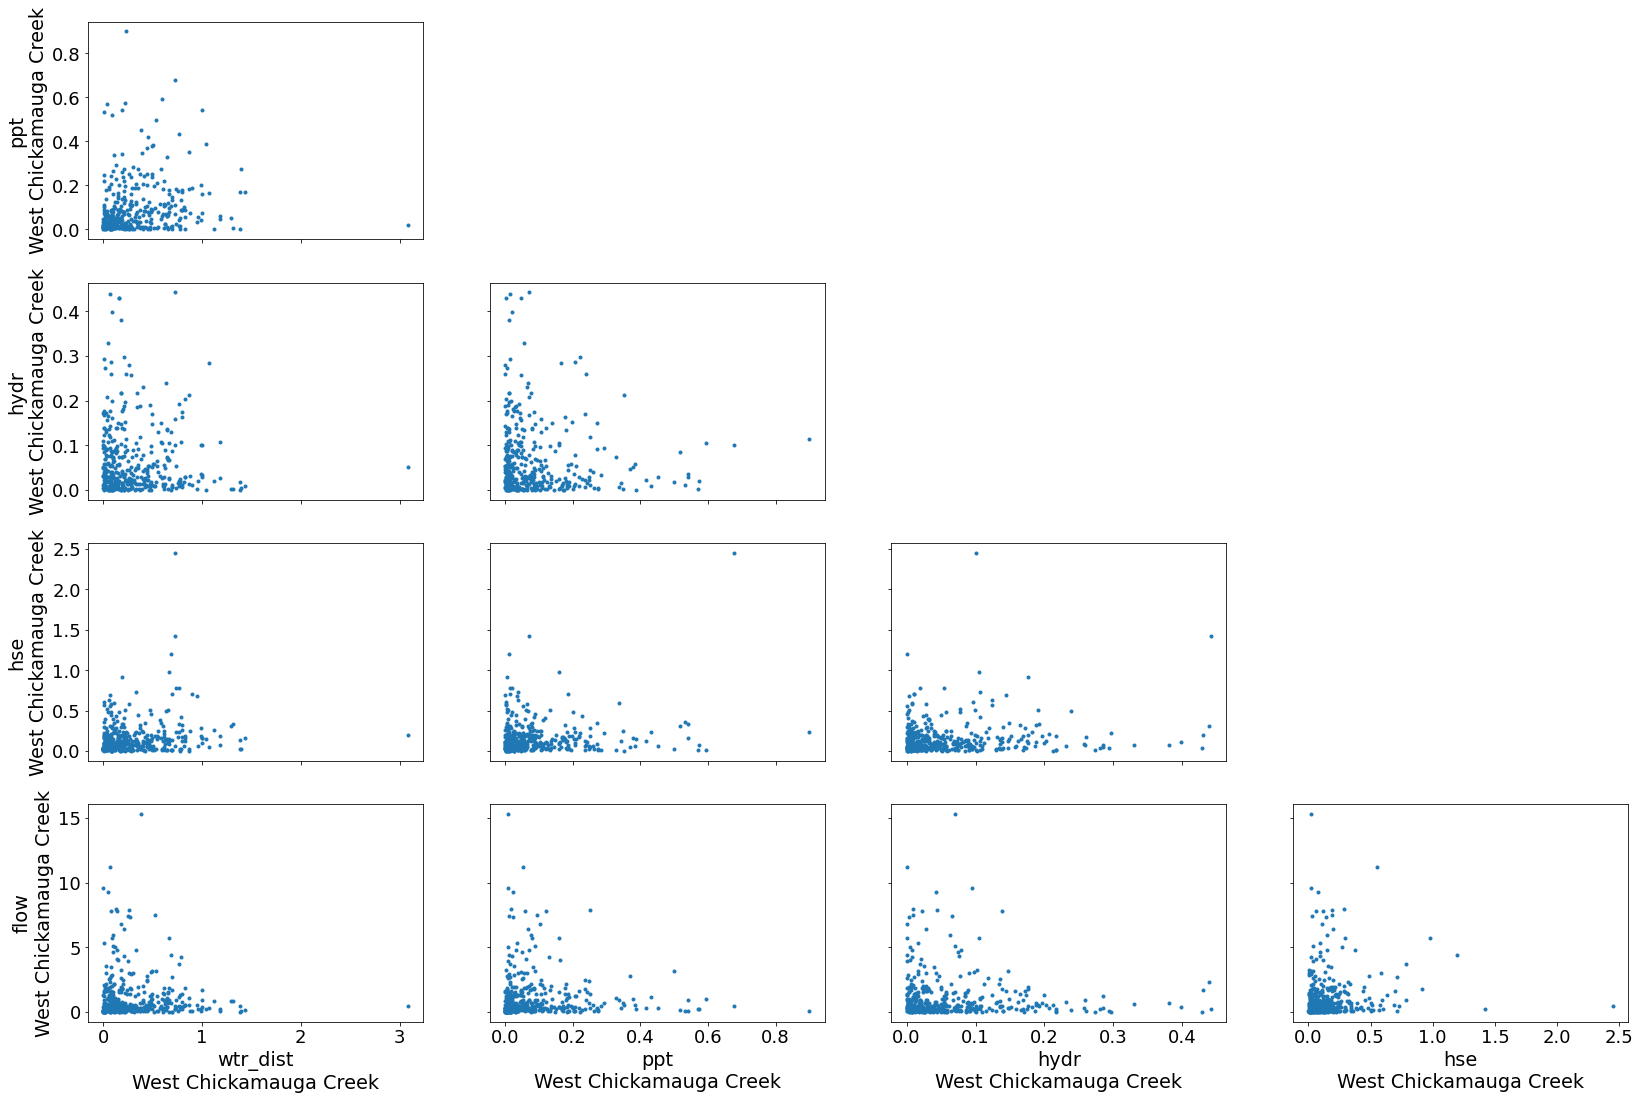

In [117]:
az.plot_pair(trace,
            var_names=var_names,
            coords=sample_coords,
            divergences=True,
            textsize=18)

In [118]:
print('correlation coefficient between:\n')
for var_a in var_names:
    for var_b in var_names:
        if var_a != var_b:
            var_a_ppc = trace.posterior[var_a][0,:,0].values
            var_b_ppc = trace.posterior[var_b][0,:,0].values
            m, c = np.polyfit(var_a_ppc,var_b_ppc,1)
            print(f"\t{var_a} and {var_b}: {m}")

correlation coefficient between:

	wtr_dist and ppt: 0.03370955103771865
	wtr_dist and hydr: -0.009107135142712382
	wtr_dist and hse: 0.030300248627335272
	wtr_dist and flow: -0.3071515321836366
	ppt and wtr_dist: 0.15470072444487332
	ppt and hydr: -0.007440801207459839
	ppt and hse: -0.071338362570054
	ppt and flow: -0.4802597140235286
	hydr and wtr_dist: -0.1386576831526813
	hydr and ppt: -0.024685531411005192
	hydr and hse: -0.022840155111263652
	hydr and flow: 0.43745664155762043
	hse and wtr_dist: 0.12631873717471204
	hse and ppt: -0.06480452637360895
	hse and hydr: -0.006254008600319234
	hse and flow: 0.2329962306001464
	flow and wtr_dist: -0.07224201076384736
	flow and ppt: -0.024613530843266663
	flow and hydr: 0.006757872533039219
	flow and hse: 0.013145116858790266
